In [1]:
import pandas as pd
import os

In [2]:
f_list = range(1, 21)

In [3]:
res_dict = {}
for i in f_list:
    res_dict[i] = pd.read_csv('res5_{}.csv'.format(i), index_col=0)

In [4]:
ensg2gene = pd.read_csv('../../../hg38_ensembl2gene.txt', sep='\t', index_col=0)
ensg2gene['gene_id'] = ensg2gene['gene_id'].str.lstrip(' ')
ensg2gene.head()

,biotype,gene_id,chr,start,stop
ensembl,,,,,
ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,chr1,11869,14409
ENSG00000227232.5,unprocessed_pseudogene,WASH7P,chr1,14404,29570
ENSG00000278267.1,miRNA,MIR6859-1,chr1,17369,17436
ENSG00000243485.5,lncRNA,MIR1302-2HG,chr1,29554,31109
ENSG00000284332.1,miRNA,MIR1302-2,chr1,30366,30503


In [5]:
for i in range(1, 21):
    res_dict[i]['symbol'] = res_dict[i].index.map(ensg2gene['gene_id'])
    res_dict[i]['biotype'] = res_dict[i].index.map(ensg2gene['biotype'])

In [6]:
res_dict[1].shape

(29965, 8)

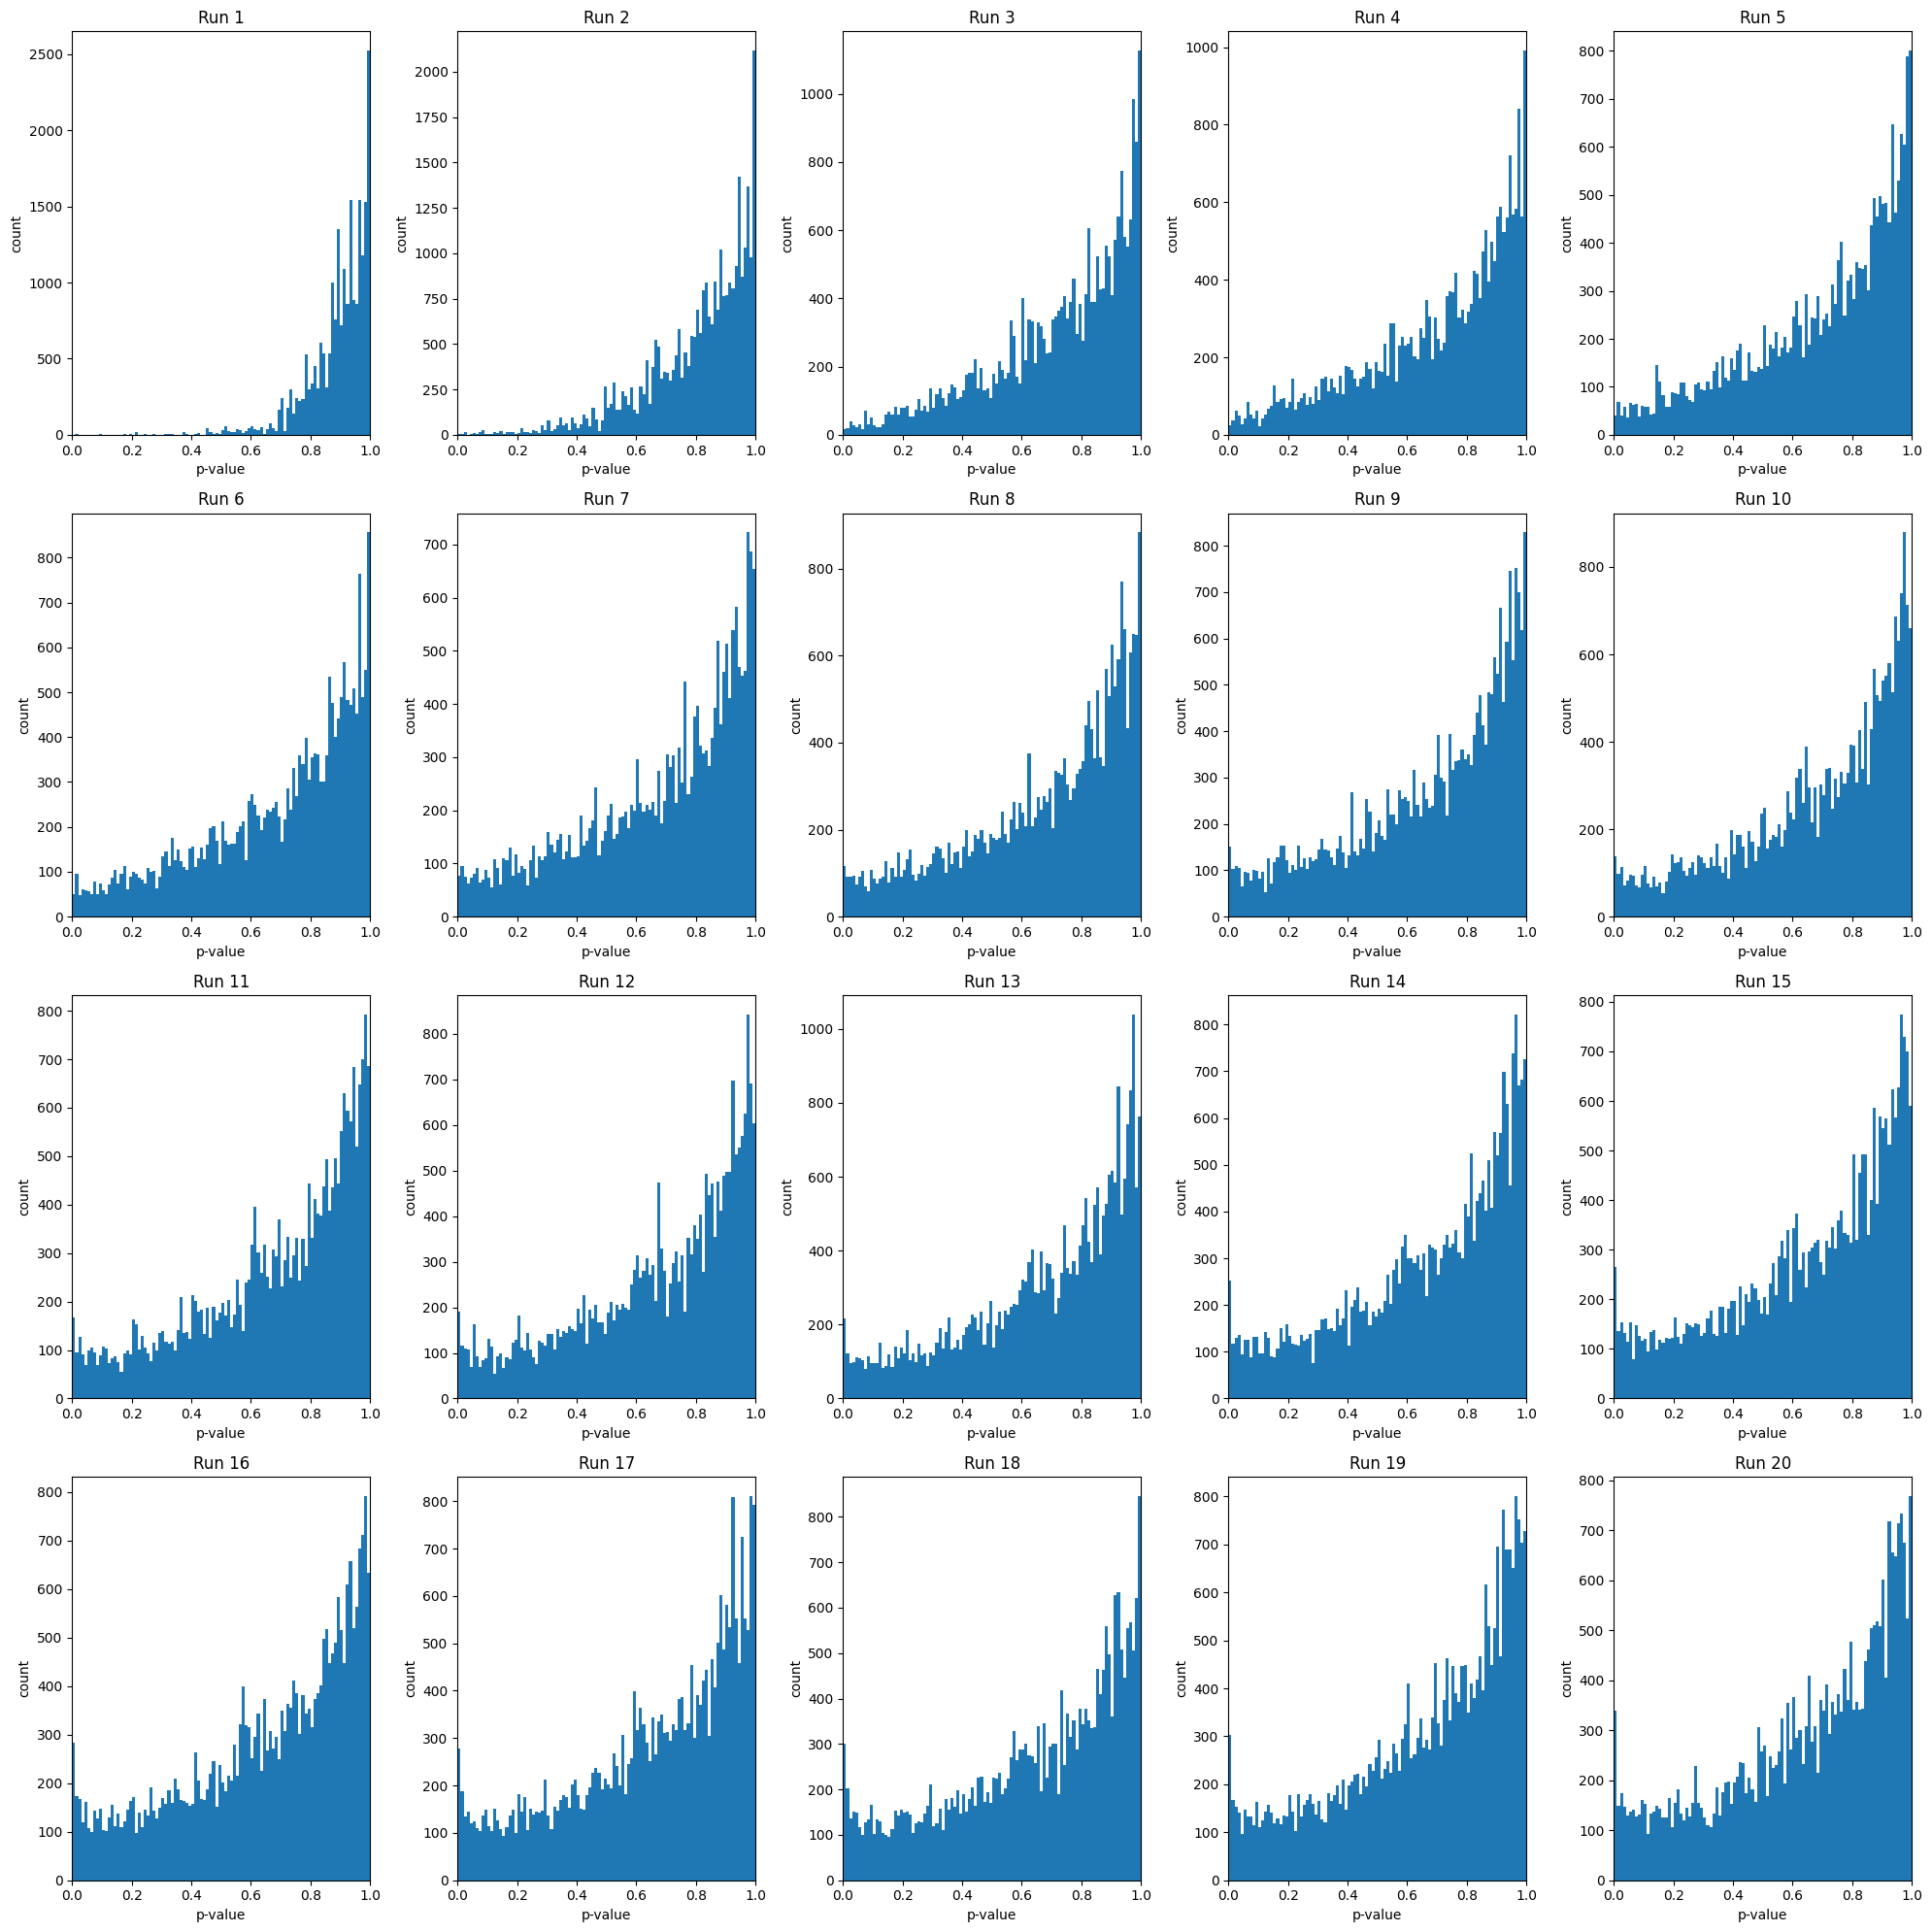

In [7]:
#plot all pval histograms on one plot in a 5x4 grid
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(1, 21):
    axes[i-1].hist(res_dict[i]['padj'], bins=100)
    axes[i-1].set_title('Run {}'.format(i))
    axes[i-1].set_xlabel('p-value')
    axes[i-1].set_ylabel('count')
    axes[i-1].set_xlim(0, 1)
    
plt.tight_layout()
plt.savefig('pval_hist.png', bbox_inches='tight', dpi=300)

In [8]:
#fit a best fit line (y = mx + b) to each histogram
import numpy as np
from scipy.optimize import curve_fit
best_fit = pd.DataFrame(columns=['run', 'slope', 'intercept'])
for i in range(1, 21):
    #drop NA values
    res_dict[i] = res_dict[i].dropna()
    hist, bins = np.histogram(res_dict[i]['padj'], bins=100)
    bins = bins[:-1]
    def func(x, m, b):
        return m*x + b
    slope_intercept, pcov = curve_fit(func, bins, hist)
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    best_fit.loc[i, 'run'] = i
    best_fit.loc[i, 'slope'] = slope
    best_fit.loc[i, 'intercept'] = intercept
#get the slope of each line
slope_df = pd.DataFrame()
for i in range(1, 21):
    slope_df.loc[i, 'slope'] = best_fit.loc[i, 'slope']
slope_df['run'] = slope_df.index
slope_df.head()

,slope,run
1,1050.413408,1
2,1097.199679,2
3,665.787324,3
4,569.299809,4
5,510.726470,5


In [9]:
slope_df.describe()

,slope,run
count,20.000000,20.00000
mean,571.689506,10.50000
std,179.145749,5.91608
min,426.927192,1.00000
25%,487.767921,5.75000
50%,516.395515,10.50000
75%,545.002000,15.25000
max,1097.199679,20.00000


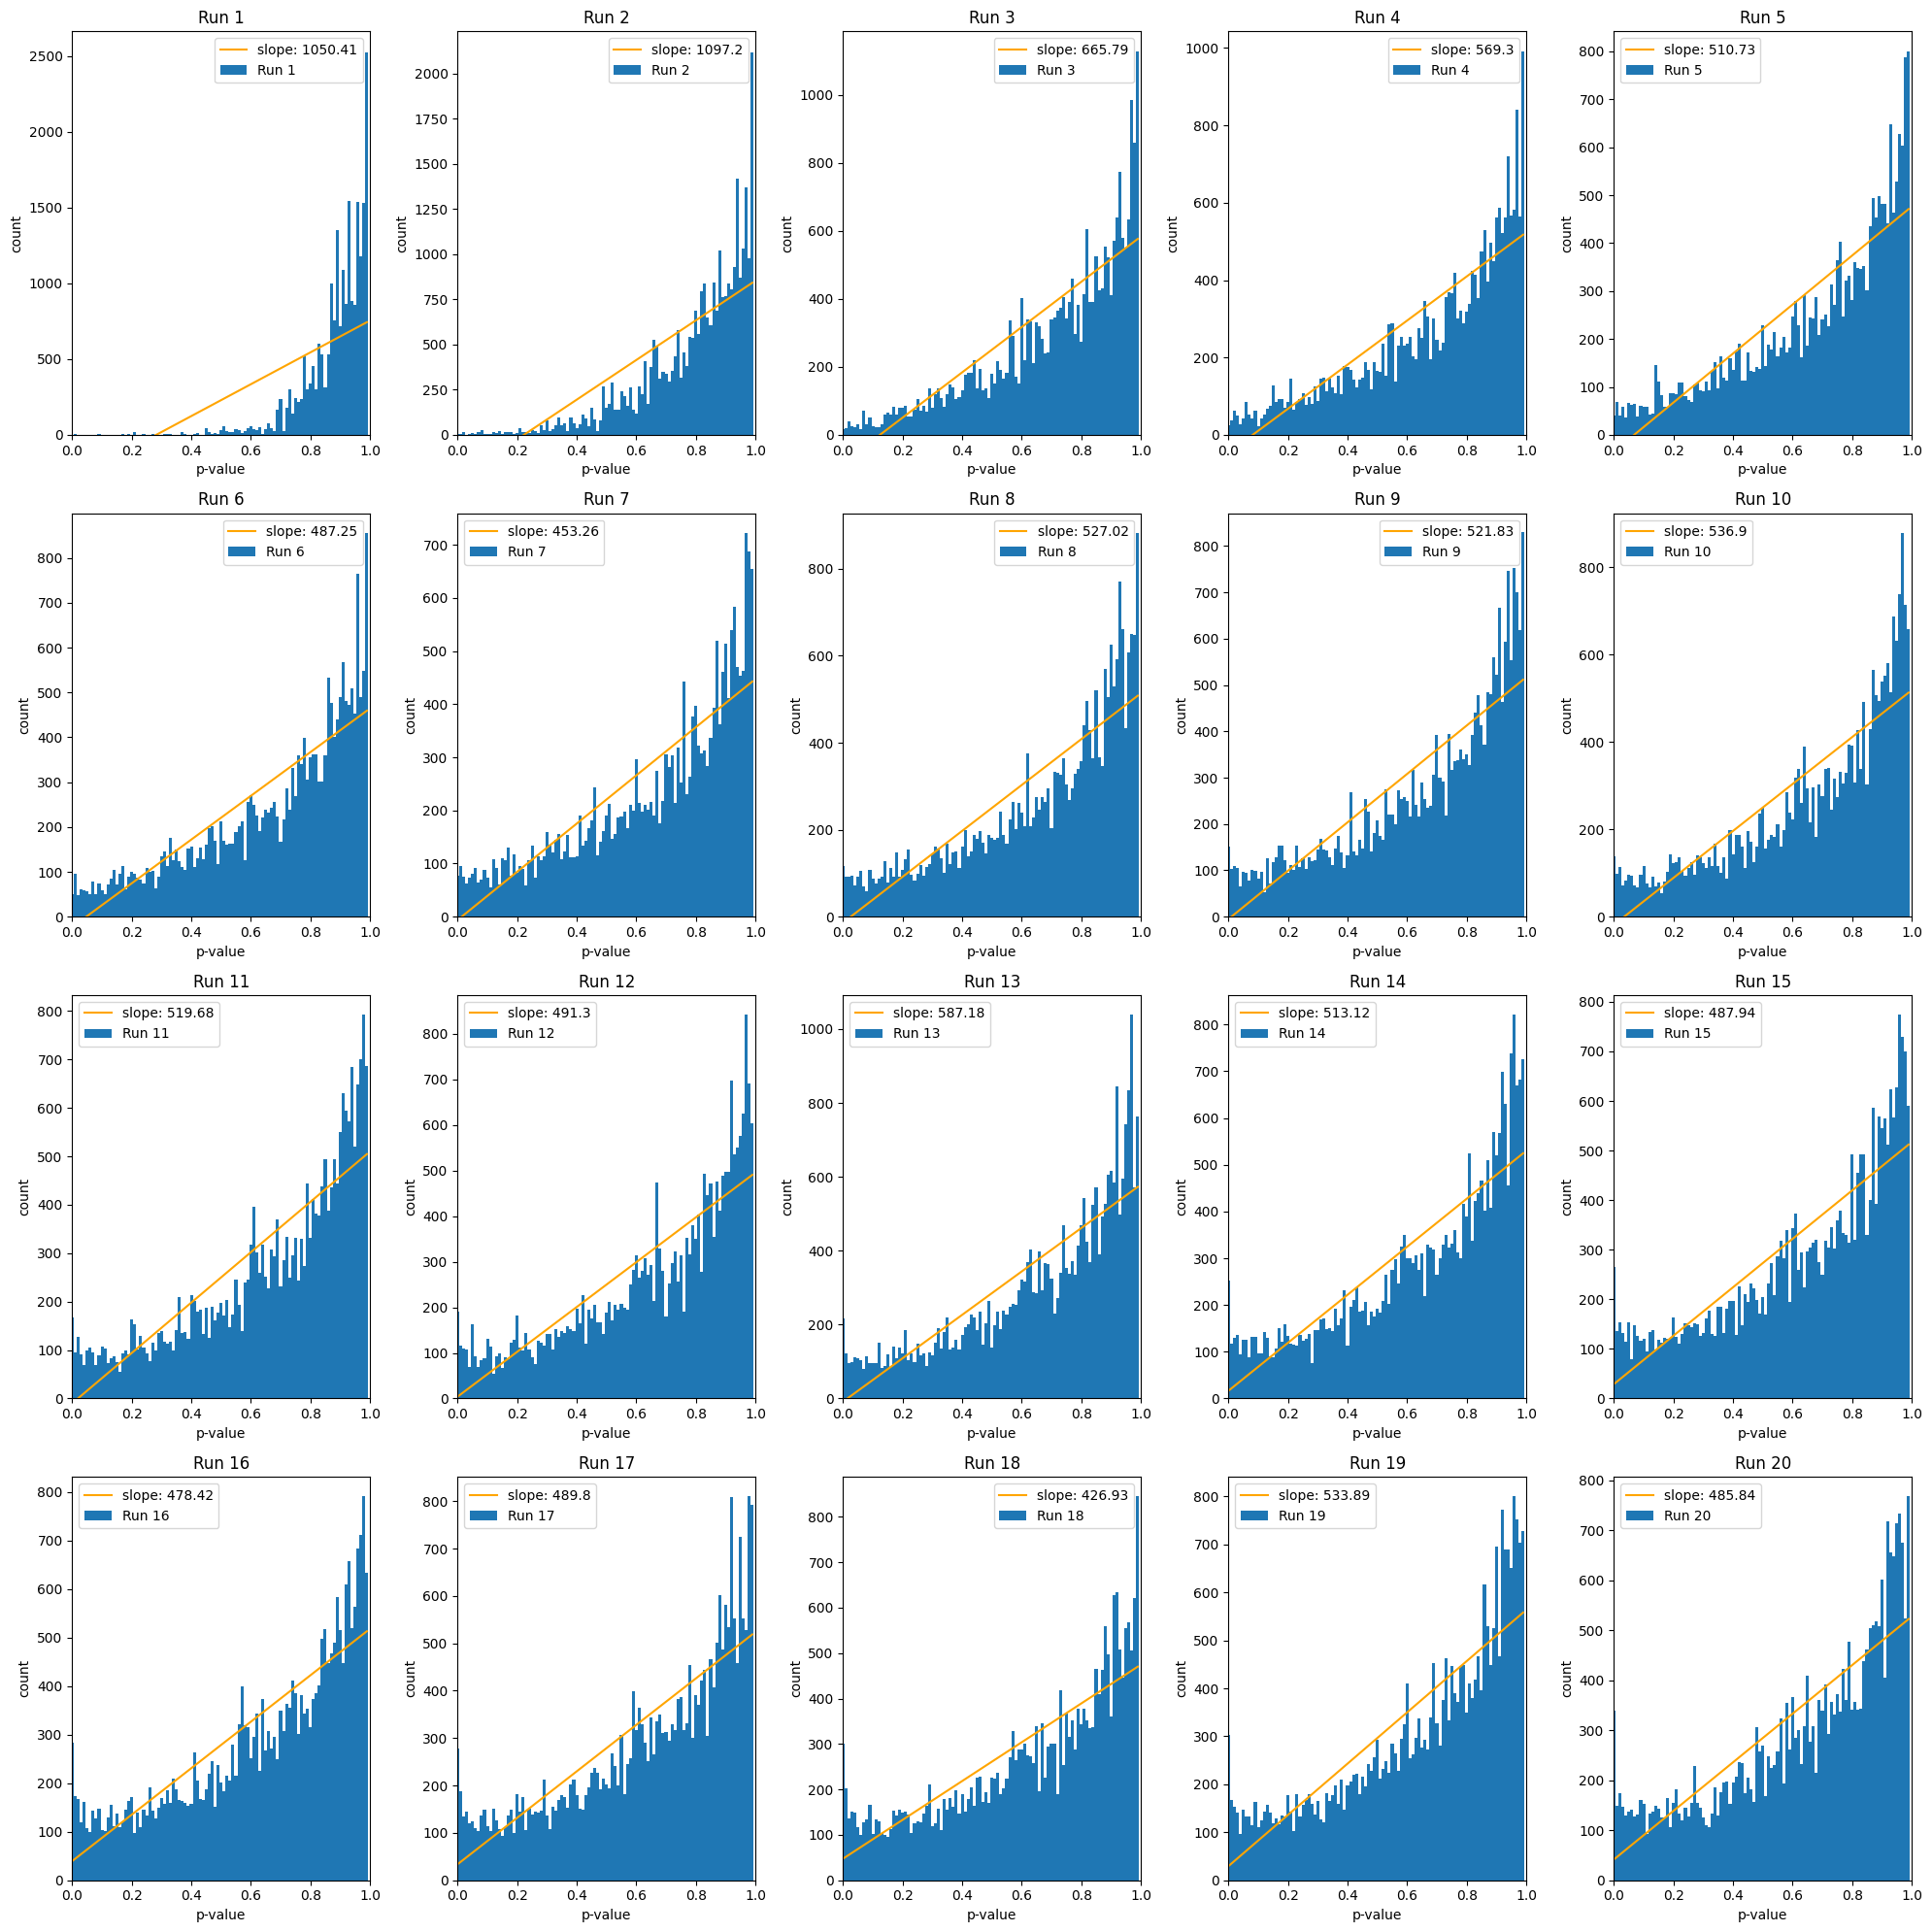

In [10]:
#plot the slopes on the histograms
#first make a function to plot the best fit line
def plot_best_fit(run, ax):
    hist, bins = np.histogram(res_dict[run]['padj'], bins=100)
    bins = bins[:-1]
    # ax.plot(bins, hist, label='Run {}'.format(run))
    #plot the histogram as bars, not lines
    ax.bar(bins, hist, width=0.01, label='Run {}'.format(run))
    #make the line orange
    ax.plot(bins, slope_df.loc[run, 'slope']*bins + best_fit.loc[run, 'intercept'], label='slope: {}'.format(round(slope_df.loc[run, 'slope'], 2)), color='orange')
    ax.legend()
    ax.set_xlabel('p-value')
    ax.set_ylabel('count')
    ax.set_title('Run {}'.format(run))
    ax.set_xlim(0, 1)
    #set the y axis to only positive values
    ax.set_ylim(0, ax.get_ylim()[1])
    return ax
#plot the best fit lines
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(1, 21):
    plot_best_fit(i, axes[i-1])
plt.tight_layout()
plt.savefig('pval_hist_best_fit.png', bbox_inches='tight', dpi=300)


In [11]:
sig_genes = {}
for i in range(1, 21):
    sig_genes[i] = res_dict[i][res_dict[i]['padj'] < 0.05].index.to_list()

In [12]:
#for each gene list get the number of genes that are in the other gene lists
overlap_df = pd.DataFrame(index=sig_genes.keys(), columns=sig_genes.keys())
for i in range(1,21):
    for j in range(1,21):
        overlap_df.loc[i, j] = len(set(sig_genes[i]).intersection(set(sig_genes[j])))


In [13]:
overlap_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,11,10,11,11,10,10,10,10,10,9,10,10,10,9,9,9,9,9,9,9
2,10,33,31,31,30,30,30,31,31,30,30,30,32,32,32,32,32,31,32,32
3,11,31,126,122,117,117,117,123,123,122,123,124,124,123,123,123,123,123,124,124
4,11,31,122,200,188,190,190,197,196,194,193,194,195,194,195,196,194,196,191,193
5,10,30,117,188,244,242,243,241,238,231,234,234,236,239,241,242,239,241,227,229
6,10,30,117,190,242,314,314,310,306,294,300,299,302,307,309,309,304,308,292,294
7,10,30,117,190,243,314,384,373,374,348,355,356,360,367,370,374,362,370,347,352
8,10,31,123,197,241,310,373,468,457,413,420,421,428,440,446,454,440,452,411,420
9,10,31,123,196,238,306,374,457,535,453,466,462,473,489,496,506,489,502,456,469
10,9,30,122,194,231,294,348,413,453,502,488,483,480,491,491,494,484,491,461,469


In [14]:
overlap_df_frac = overlap_df / overlap_df.max(axis=0)

In [15]:
overlap_df = overlap_df.astype(int)

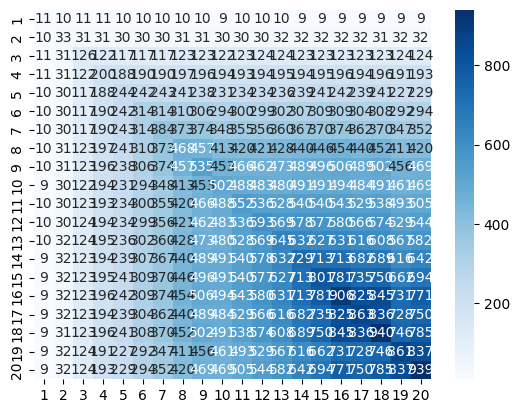

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(overlap_df, annot=True, cmap='Blues', fmt='d')
#make the plot bigger
plt.rcParams['figure.figsize'] = [15, 15]
plt.savefig('overlap_heatmap.png', bbox_inches='tight', dpi=300)

In [17]:
#create a dataframe of the top 20 genes for each run
top_20_df = pd.DataFrame(index=range(1, 21), columns=range(1, 21))
for i in range(1, 21):
    top_20_df.loc[i] = res_dict[i]['symbol'][:20].to_list()
top_20_df = top_20_df.T
top_20_df.head(15)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,SNORD3C,FSCN1,TNFAIP2,TNFAIP2,TNFAIP2,TNFAIP2,TNFAIP2,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,CSF2RB,TNFAIP2,TNFAIP2
2,TNFAIP2,TNFAIP2,FSCN1,FSCN1,FSCN1,ITGAX,CSF2RB,TNFAIP2,TNFAIP2,TNFAIP2,TNFAIP2,TNFAIP2,TNFAIP2,TNFAIP2,TLR2,TLR2,TLR2,TLR2,CSF2RB,CSF2RB
3,RNA5S1,GBP5,FGR,ITGB2,ITGB2,FSCN1,ITGAX,FGR,EMILIN2,FSCN1,GPR132,GPR132,EMILIN2,GPR132,TNFAIP2,ADM,ADM,NAIP,TLR2,NAIP
4,HCAR3,FCGR1B,GBP5,SI,CSF2RB,CSF2RB,FGR,ITGAX,ITGAX,EMILIN2,ITGAX,EMILIN2,ITGAX,ALPL,ADM,TNFAIP2,TNFAIP2,TNFAIP2,NAIP,TLR2
5,PLEK,NLRC4,FCGR1B,CSF2RB,ITGAX,ITGB2,FSCN1,GPR132,ALPL,ITGAX,FSCN1,ITGAX,GPR132,TLR2,ALPL,LIMK2,NLRC4,ADM,ADM,LIMK2
6,GBP5,HCAR3,SI,GBP5,GBP5,FGR,ITGB2,ITGB2,FGR,ALPL,EMILIN2,FSCN1,TMEM231P1,FGR,CCL19,ALPL,NAIP,ALPL,NLRC4,NOD2
7,FCGR1B,FGR,ZSWIM5,FCGR1B,RAMP3,SPI1,LINC01923,FSCN1,JAK3,GPR132,ALPL,JAK3,FSCN1,FSCN1,GPR132,NLRC4,FSCN1,GPR132,TMEM231P1,ADM
8,CCL3L3,PLEK,NLRC4,FGR,ZSWIM5,SI,SPI1,SPI1,ADM,CCL19,FGR,HAPLN3,JAK3,EMILIN2,NLRC4,CCL19,ALPL,NLRC4,A1CF,NLRC4
9,ONECUT2,SPI1,RAMP3,FCN1,LINC01923,NLRC4,HAPLN3,EMILIN2,ITGB2,HAPLN3,JAK3,ALPL,HAPLN3,ADM,NAIP,GPR132,LIMK2,EMILIN2,ITGB2,HAPLN3
10,HCAR2,NOD2,ITGAX,ITGAX,SI,RAMP3,ZSWIM5,HAPLN3,FSCN1,FGR,CCL19,CCL19,ADM,ITGB2,FGR,NAIP,GPR132,FSCN1,GPR132,ITGB2-AS1


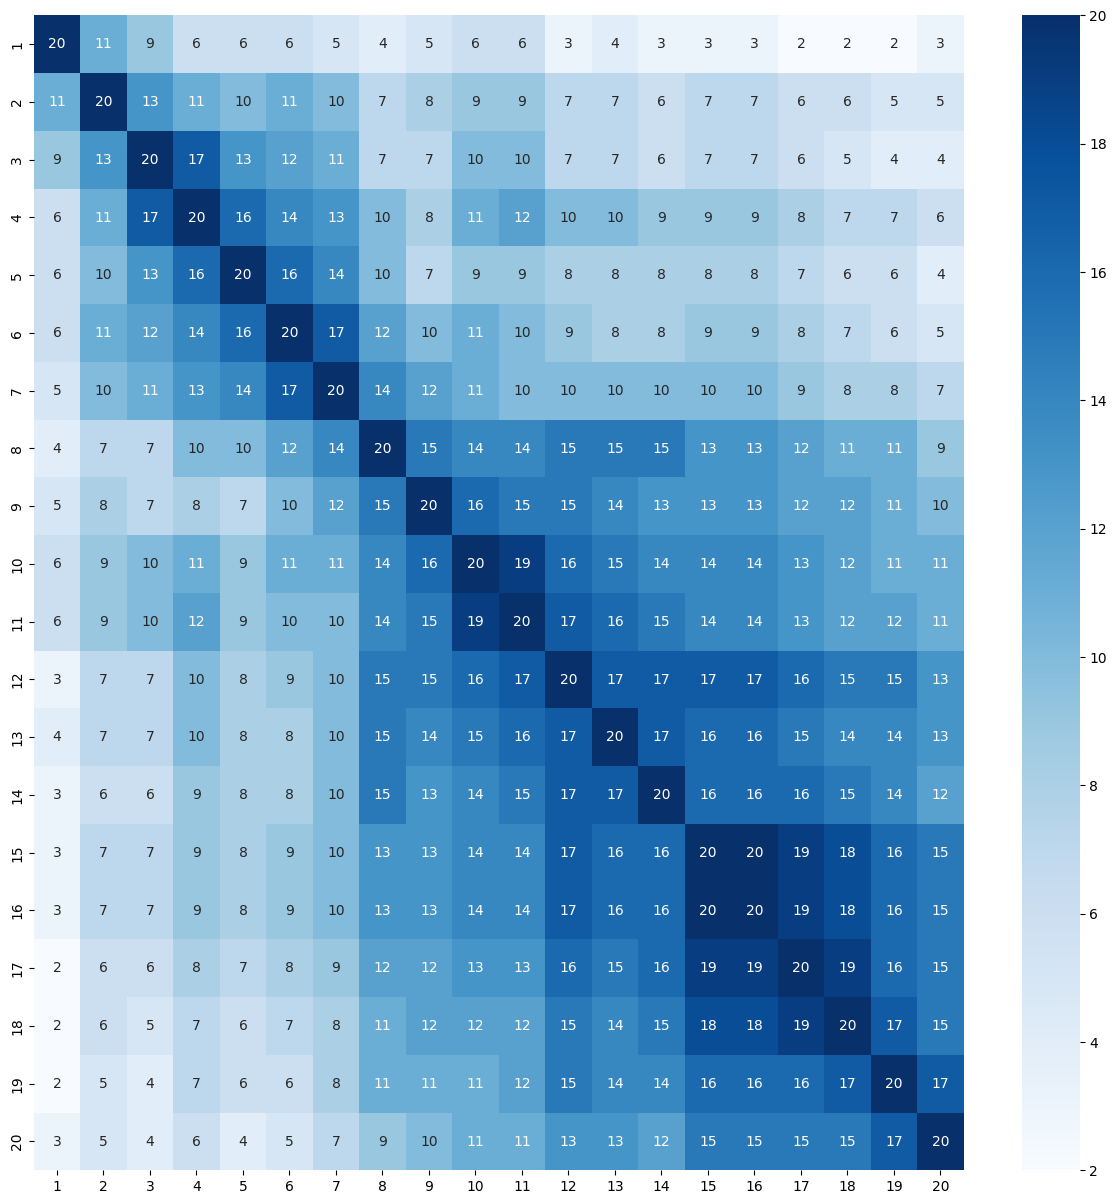

In [18]:
#make a heatmap of the top 20 genes for each run
overlap_20_df = pd.DataFrame(index=top_20_df.columns, columns=top_20_df.columns)
for i in range(1,21):
    for j in range(1,21):
        overlap_20_df.loc[i, j] = len(set(top_20_df[i]).intersection(set(top_20_df[j])))
overlap_20_df = overlap_20_df.astype(int)
sns.heatmap(overlap_20_df, annot=True, cmap='Blues', fmt='d')
#make the plot bigger
plt.rcParams['figure.figsize'] = [15, 15]
plt.savefig('top_20_heatmap.png', bbox_inches='tight', dpi=300)

In [19]:
#save run 18 to csv
res_18 = res_dict[18]
res_18.set_index('symbol', inplace=True, drop=False)
res_18.to_csv('res5_18_symbol.csv')

In [20]:
res_18.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol,biotype
symbol,,,,,,,,
CSF2RB,1408.336013,0.539294,0.076806,7.021517,2.194714e-12,5.683870e-08,CSF2RB,protein_coding
TLR2,1049.408514,0.588285,0.086894,6.770175,1.286265e-11,1.665585e-07,TLR2,protein_coding
NAIP,3875.875998,0.353731,0.053350,6.630326,3.349470e-11,2.891486e-07,NAIP,protein_coding
TNFAIP2,4540.630041,0.639195,0.097740,6.539771,6.161327e-11,3.989151e-07,TNFAIP2,protein_coding
ADM,559.950629,0.758926,0.118312,6.414633,1.411623e-10,7.311642e-07,ADM,protein_coding


In [21]:
res_18['abs_l2fc'] = res_18['log2FoldChange'].abs()
res_18.sort_values('abs_l2fc', ascending=False, inplace=True)
res_18.head()


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol,biotype,abs_l2fc
symbol,,,,,,,,,
H3C14,178.117329,-4.264876,1.185437,-3.597724,3.210138e-04,0.018339,H3C14,protein_coding,4.264876
ENSG00000260092,51.054631,3.904886,1.286235,3.035905,2.398149e-03,0.059263,ENSG00000260092,protein_coding,3.904886
KBTBD11-OT1,35.969242,3.835072,1.590901,2.410628,1.592507e-02,0.172054,KBTBD11-OT1,protein_coding,3.835072
GSTM1,183.806847,2.572911,0.437588,5.879752,4.108821e-09,0.000007,GSTM1,protein_coding,2.572911
HCAR3,312.506446,2.346643,0.449847,5.216535,1.823008e-07,0.000148,HCAR3,protein_coding,2.346643
